In [4]:
!pip install efficientnet_pytorch
!pip install grad-cam

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16426 sha256=b04c1b5ba661ee4c96493092f4454eb43665eeca68888fa419e7dd4bb03e76fe
  Stored in directory: /root/.cache/pip/wheels/9c/3f/43/e6271c7026fe08c185da2be23c98c8e87477d3db63f41f32ad
Successfully built efficientnet_pytorch
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 110.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=e22e814caebfe4e2f08e04f66274843c2f2f6c2876266aa206c08782402de810
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [5]:
import os
import cv2
import shutil
import numpy as np
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.models import mobilenet_v2, densenet121

from efficientnet_pytorch import EfficientNet

from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix
)

import seaborn as sns
import matplotlib.pyplot as plt

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image


In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
dataset_path = "/content/drive/MyDrive/dataset/CT_Kidney_dataset"
processed_path = "/content/drive/MyDrive/dataset/CT_Kidney_processed"
split_path = "/content/drive/MyDrive/dataset/CT_Kidney_split"

classes = ["Cyst", "Normal", "Stone", "Tumor"]


In [ ]:
os.makedirs(processed_path, exist_ok=True)
for cls in classes:
    os.makedirs(os.path.join(processed_path, cls), exist_ok=True)


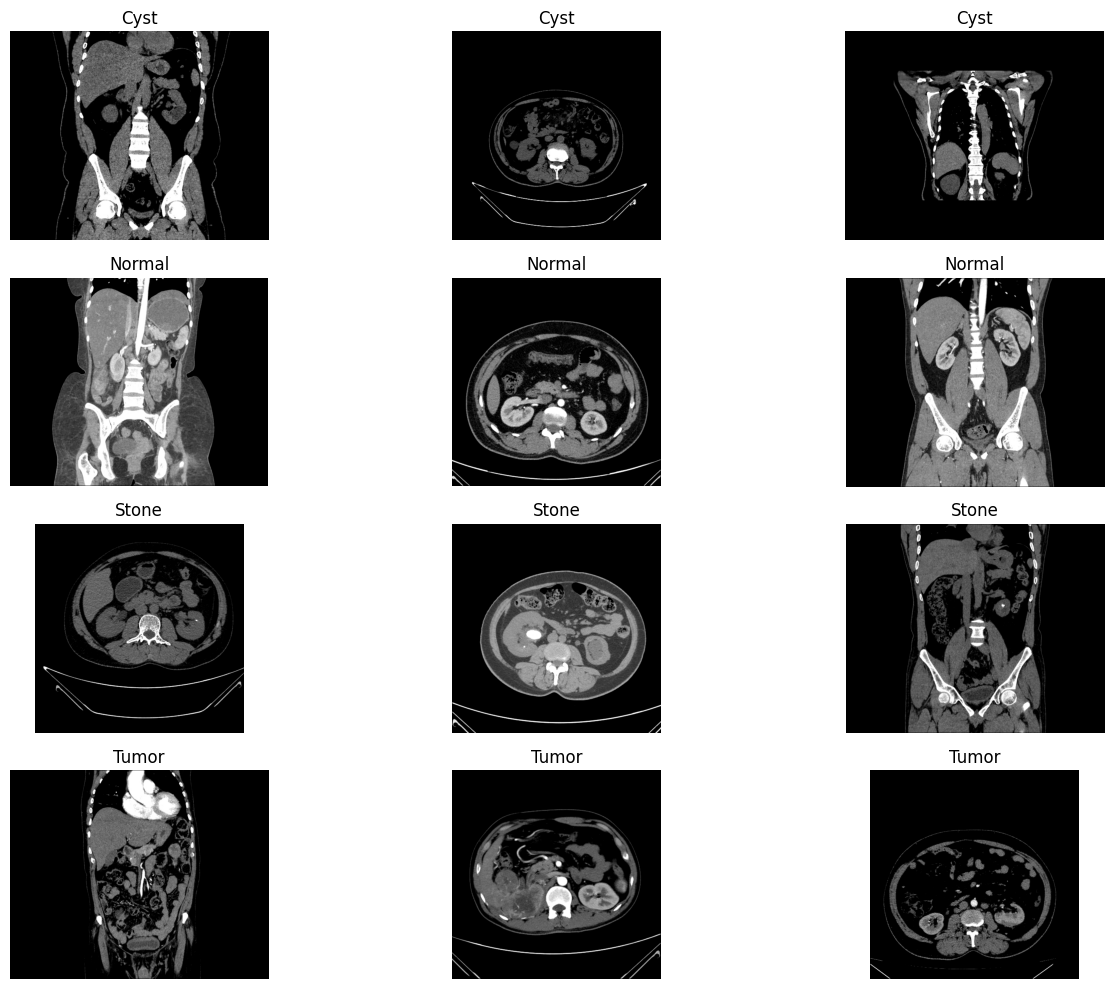

In [ ]:
# SHOW SAMPLE RAW IMAGES BEFORE PROCESSING
import random
import matplotlib.pyplot as plt
import cv2

def show_raw_samples(dataset_path, samples_per_class=3):
    plt.figure(figsize=(14, 10))
    index = 1

    for cls in classes:
        class_folder = os.path.join(dataset_path, cls)
        images = [f for f in os.listdir(class_folder) if f.lower().endswith(('.png','.jpg','.jpeg','.bmp'))]

        chosen = random.sample(images, samples_per_class)

        for img_name in chosen:
            img_path = os.path.join(class_folder, img_name)

            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            plt.subplot(len(classes), samples_per_class, index)
            plt.imshow(img)
            plt.title(f"{cls}")
            plt.axis("off")
            index += 1

    plt.tight_layout()
    plt.show()


# RUN PREVIEW
show_raw_samples(dataset_path)


In [ ]:
def preprocess_ct_image(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, (224, 224))

    blur = cv2.GaussianBlur(gray, (5,5), 0)
    filt = cv2.bilateralFilter(blur, 9, 75, 75)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(filt)

    _, mask = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    dist = cv2.distanceTransform(mask, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist, 0.7 * dist.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)

    roi = cv2.bitwise_and(enhanced, enhanced, mask=sure_fg)
    if np.sum(roi) == 0:
        roi = enhanced.copy()

    roi = roi.astype("float32") / 255.0
    roi = (roi - 0.485) / 0.229
    roi = np.stack([roi]*3, axis=-1)

    return roi


In [ ]:
for cls in classes:
    folder_in = os.path.join(dataset_path, cls)
    folder_out = os.path.join(processed_path, cls)

    imgs = [f for f in os.listdir(folder_in) if f.lower().endswith(('.png','.jpg','.jpeg'))]
    print(f"\nProcessing {cls} ({len(imgs)} images)...")

    for img_name in tqdm(imgs):
        img = cv2.imread(os.path.join(folder_in, img_name))
        if img is None:
            continue
        processed = preprocess_ct_image(img)
        save_path = os.path.join(folder_out, img_name.rsplit(".",1)[0] + ".npy")
        np.save(save_path, processed)



Processing Cyst (3709 images)...


100%|██████████| 3709/3709 [17:56<00:00,  3.44it/s]



Processing Normal (5077 images)...


100%|██████████| 5077/5077 [04:33<00:00, 18.55it/s]



Processing Stone (1377 images)...


100%|██████████| 1377/1377 [01:15<00:00, 18.24it/s]



Processing Tumor (2283 images)...


100%|██████████| 2283/2283 [01:51<00:00, 20.46it/s]


In [ ]:
for split in ["train","val","test"]:
    for cls in classes:
        os.makedirs(os.path.join(split_path, split, cls), exist_ok=True)

for cls in classes:
    folder = os.path.join(processed_path, cls)
    files = [f for f in os.listdir(folder) if f.endswith(".npy")]

    train_f, temp_f = train_test_split(files, test_size=0.30, random_state=42)
    val_f, test_f = train_test_split(temp_f, test_size=1/3, random_state=42)

    for f in train_f:
        shutil.copy(os.path.join(folder, f), os.path.join(split_path, "train", cls, f))

    for f in val_f:
        shutil.copy(os.path.join(folder, f), os.path.join(split_path, "val", cls, f))

    for f in test_f:
        shutil.copy(os.path.join(folder, f), os.path.join(split_path, "test", cls, f))


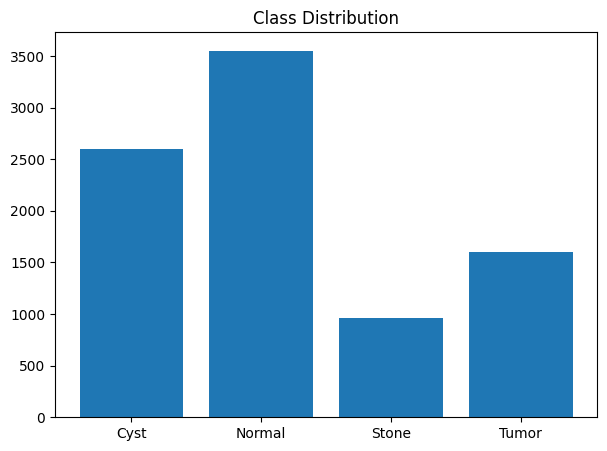

In [ ]:
counts = {}
for cls in classes:
    folder = os.path.join(split_path, "train", cls)
    counts[cls] = len(os.listdir(folder))

plt.figure(figsize=(7,5))
plt.bar(counts.keys(), counts.values())
plt.title("Class Distribution")
plt.show()


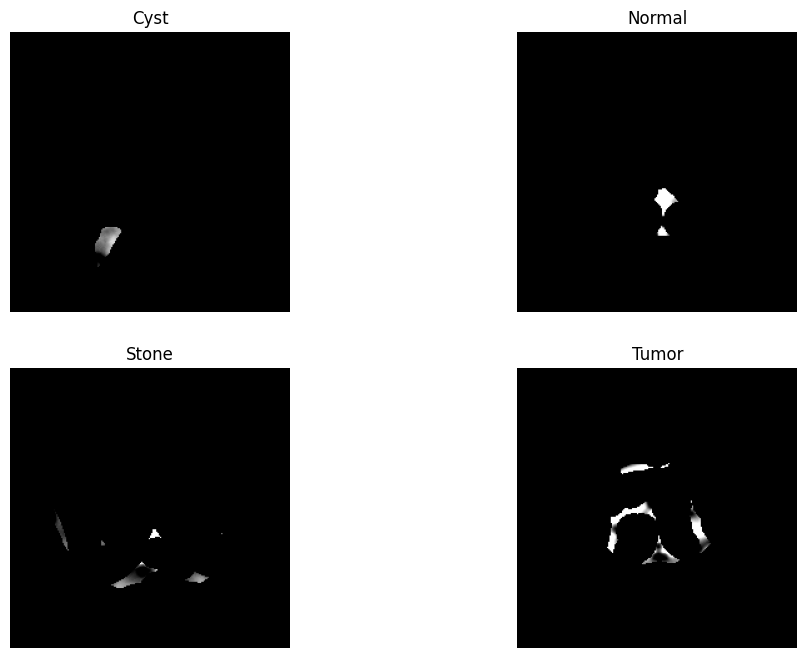

In [ ]:
plt.figure(figsize=(12,8))

for i, cls in enumerate(classes):
    folder = os.path.join(split_path, "train", cls)
    sample = random.choice(os.listdir(folder))
    img = np.load(os.path.join(folder, sample))

    plt.subplot(2,2,i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")

plt.show()


In [ ]:
class KidneyNPYDataset(Dataset):
    def __init__(self, root, transform=None):
        self.transform = transform
        self.classes = classes
        self.samples = []

        for label, cls in enumerate(self.classes):
            folder = os.path.join(root, cls)
            for f in os.listdir(folder):
                if f.endswith(".npy"):
                    self.samples.append((os.path.join(folder, f), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = np.load(path)
        if self.transform:
            img = self.transform(img)
        return img, label

train_transform = T.Compose([
    T.ToTensor(),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.RandomRotation(15),
    T.RandomResizedCrop(224, scale=(0.9,1.1)),
])

val_transform = T.Compose([T.ToTensor()])
test_transform = T.Compose([T.ToTensor()])

train_ds = KidneyNPYDataset(split_path+"/train", transform=train_transform)
val_ds   = KidneyNPYDataset(split_path+"/val", transform=val_transform)
test_ds  = KidneyNPYDataset(split_path+"/test", transform=test_transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

def train_model(model, train_loader, val_loader, epochs=20, save_path="best.pth"):
    best_loss = float("inf")
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(epochs):
        # ---------------------------
        # Training
        # ---------------------------
        model.train()
        t_loss, correct_train, total_train = 0, 0, 0

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            t_loss += loss.item()
            preds = outputs.argmax(1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_acc = correct_train / total_train

        # ---------------------------
        # Validation
        # ---------------------------
        model.eval()
        v_loss, correct_val, total_val = 0, 0, 0

        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                v_loss += criterion(outputs, labels).item()

                preds = outputs.argmax(1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_acc = correct_val / total_val

        # ---------------------------
        # Store Metrics
        # ---------------------------
        history["train_loss"].append(t_loss)
        history["val_loss"].append(v_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        scheduler.step(v_loss)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss {t_loss:.2f}, Acc {train_acc:.3f} | "
              f"Val Loss {v_loss:.2f}, Acc {val_acc:.3f}")

        # ---------------------------
        # Save Best Model
        # ---------------------------
        if v_loss < best_loss:
            best_loss = v_loss
            torch.save(model.state_dict(), save_path)
            print("Best model saved!")

    return history


In [ ]:
def get_mobilenetv2():
    model = mobilenet_v2(weights="IMAGENET1K_V1")
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, 4)
    return model

mobilenet = get_mobilenetv2().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mobilenet.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=3)

mobilenet_history = train_model(
    mobilenet, train_loader, val_loader,
    save_path="/content/drive/MyDrive/mobilenetv2_best.pth"
)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 102MB/s] 


Epoch 1/20 | Train Loss 300.20, Acc 0.547 | Val Loss 94.69, Acc 0.524
Best model saved!
Epoch 2/20 | Train Loss 255.05, Acc 0.626 | Val Loss 89.51, Acc 0.510
Best model saved!
Epoch 3/20 | Train Loss 234.41, Acc 0.662 | Val Loss 65.47, Acc 0.653
Best model saved!
Epoch 4/20 | Train Loss 214.89, Acc 0.688 | Val Loss 59.36, Acc 0.700
Best model saved!
Epoch 5/20 | Train Loss 198.17, Acc 0.715 | Val Loss 48.37, Acc 0.762
Best model saved!
Epoch 6/20 | Train Loss 185.98, Acc 0.731 | Val Loss 50.60, Acc 0.753
Epoch 7/20 | Train Loss 176.44, Acc 0.745 | Val Loss 49.56, Acc 0.753
Epoch 8/20 | Train Loss 160.03, Acc 0.773 | Val Loss 47.65, Acc 0.763
Best model saved!
Epoch 9/20 | Train Loss 151.10, Acc 0.787 | Val Loss 45.29, Acc 0.780
Best model saved!
Epoch 10/20 | Train Loss 140.40, Acc 0.803 | Val Loss 42.81, Acc 0.803
Best model saved!
Epoch 11/20 | Train Loss 130.52, Acc 0.817 | Val Loss 35.82, Acc 0.824
Best model saved!
Epoch 12/20 | Train Loss 128.14, Acc 0.827 | Val Loss 39.11, Acc 0

In [ ]:
def get_efficientnet_b0():
    model = EfficientNet.from_pretrained('efficientnet-b0')
    model._fc = nn.Linear(model._fc.in_features, 4)
    return model

eff = get_efficientnet_b0().to(device)
optimizer = torch.optim.Adam(eff.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=3)

efficientnet_history = train_model(
    eff, train_loader, val_loader,
    save_path="/content/drive/MyDrive/efficientnet_b0_best.pth"
)


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


100%|██████████| 20.4M/20.4M [00:00<00:00, 114MB/s] 


Loaded pretrained weights for efficientnet-b0
Epoch 1/20 | Train Loss 311.59, Acc 0.516 | Val Loss 88.18, Acc 0.526
Best model saved!
Epoch 2/20 | Train Loss 246.30, Acc 0.632 | Val Loss 81.03, Acc 0.563
Best model saved!
Epoch 3/20 | Train Loss 204.36, Acc 0.702 | Val Loss 78.94, Acc 0.567
Best model saved!
Epoch 4/20 | Train Loss 176.60, Acc 0.747 | Val Loss 47.99, Acc 0.764
Best model saved!
Epoch 5/20 | Train Loss 148.63, Acc 0.785 | Val Loss 58.95, Acc 0.699
Epoch 6/20 | Train Loss 127.26, Acc 0.823 | Val Loss 55.71, Acc 0.721
Epoch 7/20 | Train Loss 106.90, Acc 0.854 | Val Loss 27.81, Acc 0.871
Best model saved!
Epoch 8/20 | Train Loss 93.90, Acc 0.868 | Val Loss 32.51, Acc 0.853
Epoch 9/20 | Train Loss 85.74, Acc 0.885 | Val Loss 17.71, Acc 0.922
Best model saved!
Epoch 10/20 | Train Loss 77.75, Acc 0.896 | Val Loss 23.82, Acc 0.885
Epoch 11/20 | Train Loss 66.48, Acc 0.909 | Val Loss 41.91, Acc 0.796
Epoch 12/20 | Train Loss 63.30, Acc 0.917 | Val Loss 13.82, Acc 0.943
Best mod

In [ ]:
def get_densenet121():
    model = densenet121(weights="IMAGENET1K_V1")
    model.classifier = nn.Linear(model.classifier.in_features, 4)
    return model

dense = get_densenet121().to(device)
optimizer = torch.optim.Adam(dense.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=3)

densenet_history = train_model(
    dense, train_loader, val_loader,
    save_path="/content/drive/MyDrive/densenet121_best.pth"
)


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 177MB/s]


Epoch 1/20 | Train Loss 308.24, Acc 0.535 | Val Loss 84.59, Acc 0.551
Best model saved!
Epoch 2/20 | Train Loss 267.73, Acc 0.604 | Val Loss 71.23, Acc 0.642
Best model saved!
Epoch 3/20 | Train Loss 247.30, Acc 0.635 | Val Loss 66.94, Acc 0.668
Best model saved!
Epoch 4/20 | Train Loss 233.68, Acc 0.659 | Val Loss 99.42, Acc 0.589
Epoch 5/20 | Train Loss 215.28, Acc 0.688 | Val Loss 289.23, Acc 0.367
Epoch 6/20 | Train Loss 201.32, Acc 0.712 | Val Loss 771.89, Acc 0.300
Epoch 7/20 | Train Loss 189.16, Acc 0.731 | Val Loss 812.18, Acc 0.298
Epoch 8/20 | Train Loss 149.12, Acc 0.789 | Val Loss 35.86, Acc 0.837
Best model saved!
Epoch 9/20 | Train Loss 131.62, Acc 0.817 | Val Loss 32.75, Acc 0.848
Best model saved!
Epoch 10/20 | Train Loss 121.09, Acc 0.835 | Val Loss 30.76, Acc 0.855
Best model saved!
Epoch 11/20 | Train Loss 112.43, Acc 0.845 | Val Loss 28.30, Acc 0.879
Best model saved!
Epoch 12/20 | Train Loss 105.38, Acc 0.858 | Val Loss 26.86, Acc 0.881
Best model saved!
Epoch 13/2

In [ ]:
def evaluate_model(model_fn, path):
    model = model_fn().to(device)
    model.load_state_dict(torch.load(path))
    model.eval()

    preds, labels_list = [], []

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            out = model(imgs)
            preds.extend(out.argmax(1).cpu().numpy())
            labels_list.extend(labels.cpu().numpy())

    print("Accuracy:", accuracy_score(labels_list, preds)*100)
    print(classification_report(labels_list, preds, target_names=classes))

    cm = confusion_matrix(labels_list, preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.show()


Accuracy: 89.8876404494382
              precision    recall  f1-score   support

        Cyst       0.93      0.93      0.93       371
      Normal       0.95      0.90      0.92       508
       Stone       0.71      0.79      0.75       138
       Tumor       0.88      0.92      0.90       229

    accuracy                           0.90      1246
   macro avg       0.87      0.88      0.87      1246
weighted avg       0.90      0.90      0.90      1246



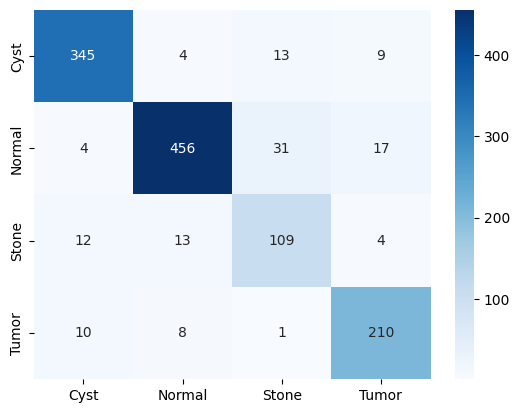

In [ ]:
evaluate_model(get_mobilenetv2, "/content/drive/MyDrive/mobilenetv2_best.pth")



Loaded pretrained weights for efficientnet-b0
Accuracy: 97.8330658105939
              precision    recall  f1-score   support

        Cyst       0.98      0.98      0.98       371
      Normal       0.98      0.99      0.99       508
       Stone       0.97      0.95      0.96       138
       Tumor       0.97      0.97      0.97       229

    accuracy                           0.98      1246
   macro avg       0.98      0.97      0.97      1246
weighted avg       0.98      0.98      0.98      1246



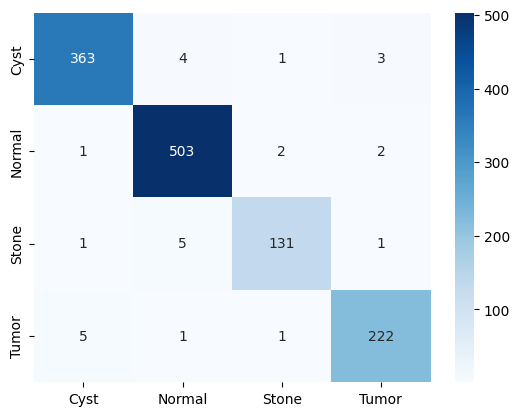

In [ ]:
evaluate_model(get_efficientnet_b0, "/content/drive/MyDrive/efficientnet_b0_best.pth")


Accuracy: 92.69662921348315
              precision    recall  f1-score   support

        Cyst       0.92      0.95      0.94       371
      Normal       0.94      0.94      0.94       508
       Stone       0.89      0.86      0.87       138
       Tumor       0.93      0.89      0.91       229

    accuracy                           0.93      1246
   macro avg       0.92      0.91      0.92      1246
weighted avg       0.93      0.93      0.93      1246



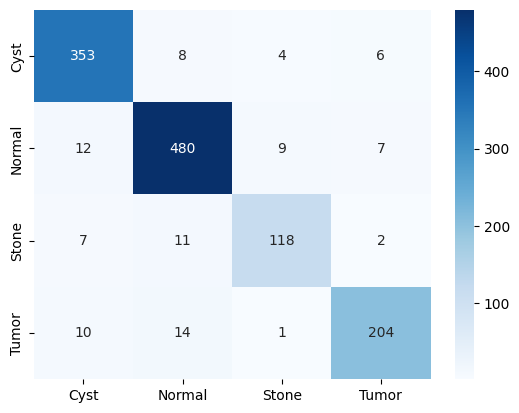

In [ ]:
evaluate_model(get_densenet121, "/content/drive/MyDrive/densenet121_best.pth")

In [ ]:
def plot_curves(history, title):
    epochs = range(1, len(history["train_loss"])+1)

    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], label="Train")
    plt.plot(epochs, history["val_loss"], label="Val")
    plt.title(title + " Loss")
    plt.grid()
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["val_acc"], label="Val Acc")
    plt.title(title + " Accuracy")
    plt.grid()
    plt.legend()

    plt.show()




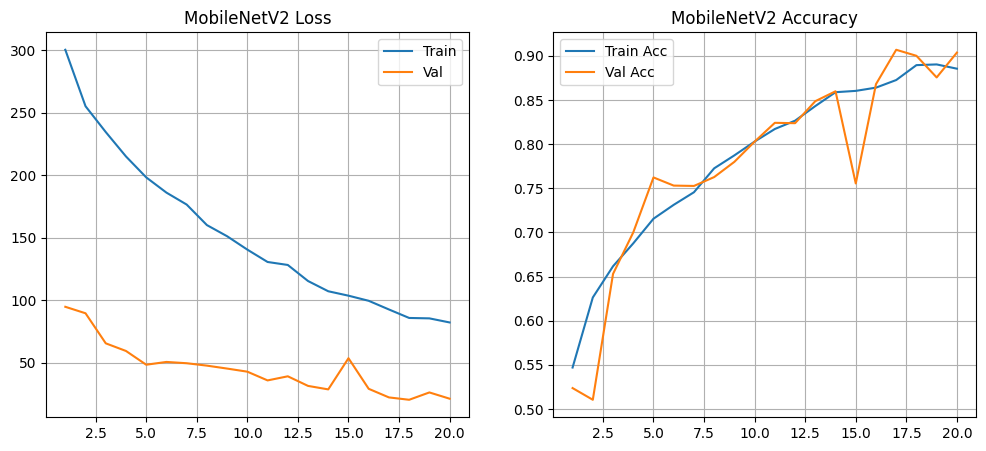

In [ ]:
plot_curves(mobilenet_history, "MobileNetV2")


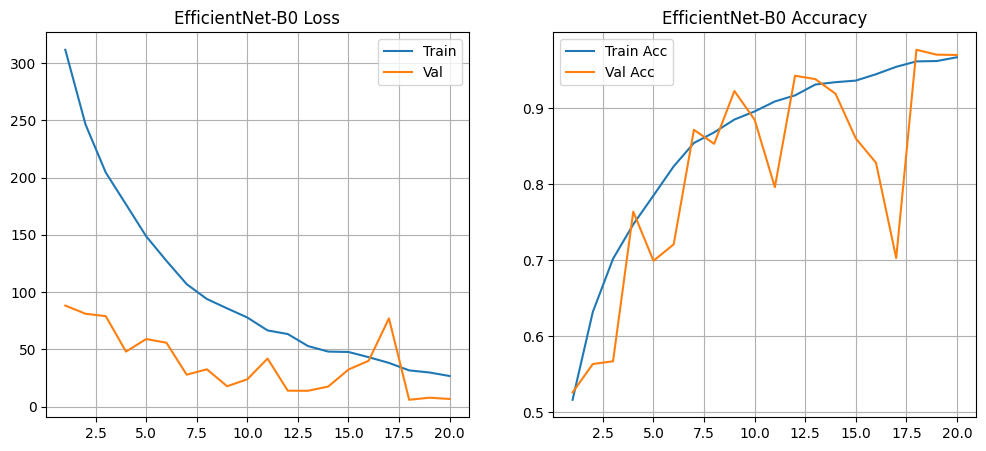

In [ ]:
plot_curves(efficientnet_history, "EfficientNet-B0")


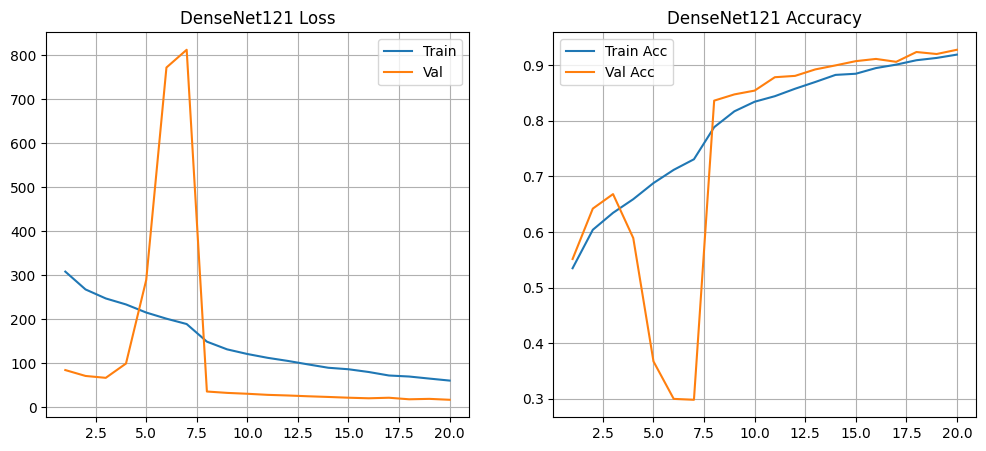

In [ ]:
plot_curves(densenet_history, "DenseNet121")

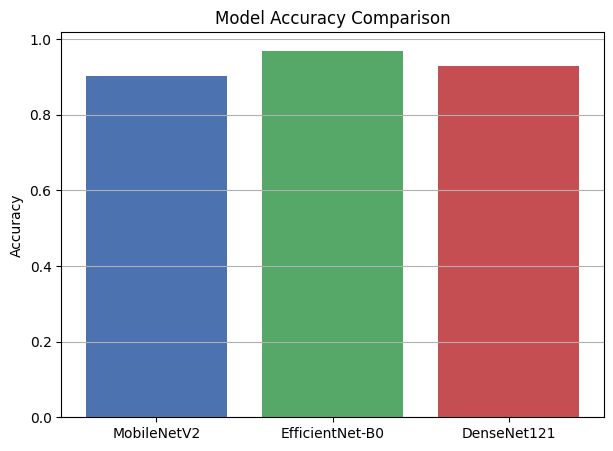

In [ ]:
accuracy = {
    "MobileNetV2": mobilenet_history["val_acc"][-1],
    "EfficientNet-B0": efficientnet_history["val_acc"][-1],
    "DenseNet121": densenet_history["val_acc"][-1],
}

plt.figure(figsize=(7,5))
plt.bar(accuracy.keys(), accuracy.values(), color=['#4c72b0','#55a868','#c44e52'])
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.grid(axis='y')
plt.show()


In [ ]:
def grad_cam_visual(model_fn, model_path, img_path):
    model = model_fn().to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # Load model-input image (normalized)
    img_norm = np.load(img_path)

    # ------------------------------
    # 1. Convert to tensor for model
    # ------------------------------
    tensor = torch.tensor(img_norm).permute(2,0,1).unsqueeze(0).float().to(device)

    # ------------------------------
    # 2. Denormalize for visualization
    # ------------------------------
    img_vis = img_norm.copy()

    # undo: (img - mean) / std
    img_vis = (img_vis * 0.229) + 0.485  # std, mean
    img_vis = np.clip(img_vis, 0, 1).astype(np.float32)

    # ------------------------------
    # 3. Select correct last conv layer
    # ------------------------------
    if "MobileNet" in str(model_fn):
        target_layer = model.features[-1]
    elif "efficientnet" in str(model_fn).lower():
        target_layer = model._blocks[-1]
    else:
        target_layer = model.features[-1]

    cam = GradCAM(model=model, target_layers=[target_layer])
    grayscale_cam = cam(input_tensor=tensor, targets=None)[0]

    # ------------------------------
    # 4. Overlay heatmap on denormalized image
    # ------------------------------
    result = show_cam_on_image(img_vis, grayscale_cam, use_rgb=True)

    plt.figure(figsize=(6,6))
    plt.imshow(result)
    plt.axis("off")
    plt.title("Grad-CAM Heatmap")
    plt.show()


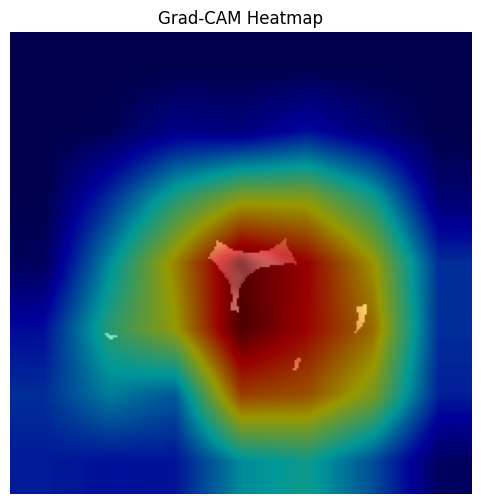

Loaded pretrained weights for efficientnet-b0


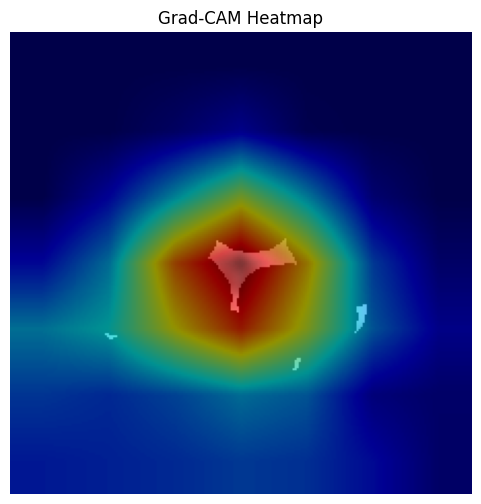

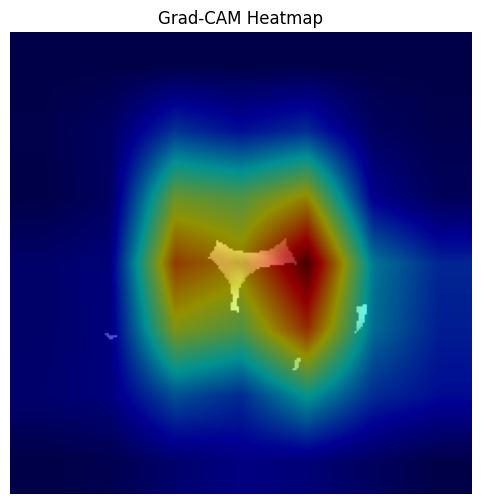

In [ ]:
grad_cam_visual(get_mobilenetv2, "/content/drive/MyDrive/mobilenetv2_best.pth", sample_path)
grad_cam_visual(get_efficientnet_b0, "/content/drive/MyDrive/efficientnet_b0_best.pth", sample_path)
grad_cam_visual(get_densenet121, "/content/drive/MyDrive/densenet121_best.pth", sample_path)


In [ ]:
def show_predictions(model_fn, model_path, n=6):
    # Load model
    model = model_fn().to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # Pick random samples
    samples = random.sample(test_ds.samples, n)

    plt.figure(figsize=(14, 8))

    for i, (path, label) in enumerate(samples):
        # Load preprocessed .npy image
        img_norm = np.load(path)

        # Model input
        tensor = torch.tensor(img_norm).permute(2,0,1).unsqueeze(0).float().to(device)

        # Forward pass
        with torch.no_grad():
            out = model(tensor)

        # Softmax prediction (detached)
        prob = torch.softmax(out, dim=1).detach().cpu().numpy()[0]
        pred_idx = np.argmax(prob)
        pred_label = classes[pred_idx]
        confidence = prob[pred_idx] * 100

        # Denormalize for display
        img_vis = (img_norm * 0.229) + 0.485
        img_vis = np.clip(img_vis, 0, 1)

        # Plot
        plt.subplot(2, 3, i + 1)
        plt.imshow(img_vis)
        plt.axis("off")
        plt.title(
            f"True: {classes[label]}\nPred: {pred_label}\nConf: {confidence:.1f}%"
        )

    plt.tight_layout()
    plt.show()


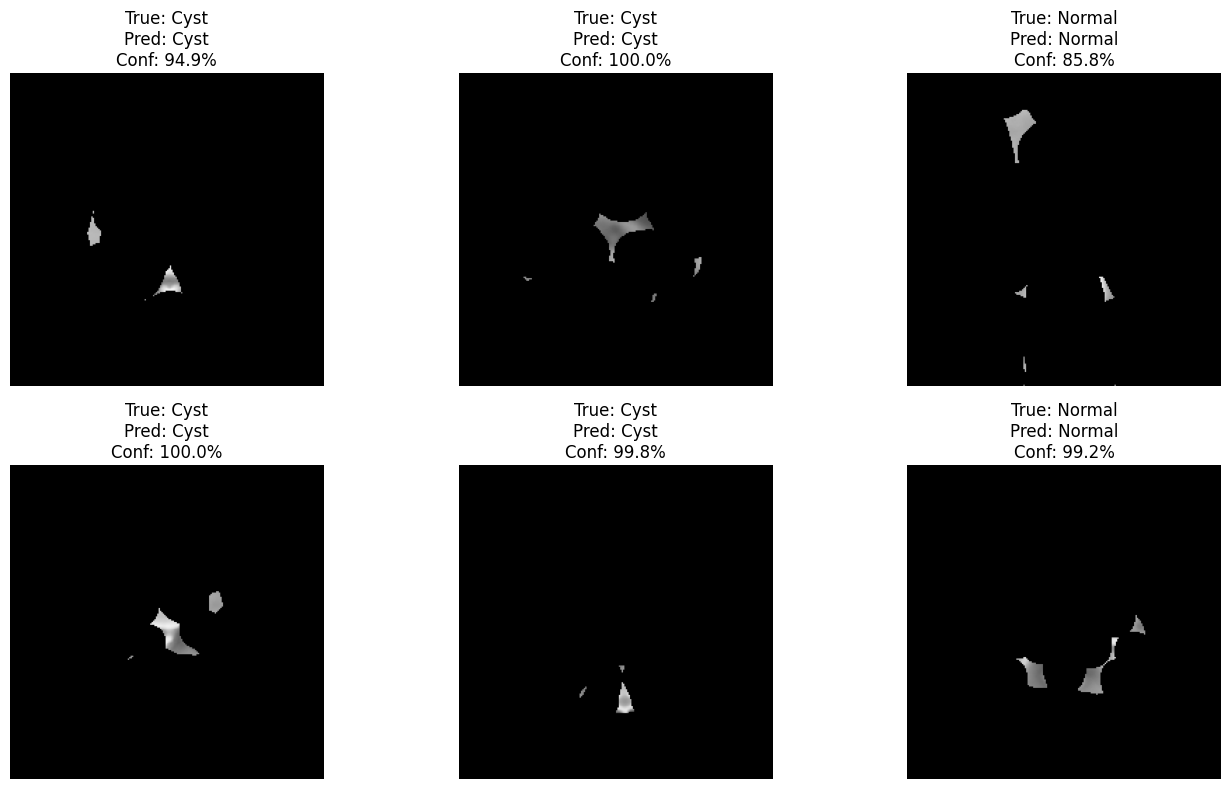

In [ ]:
show_predictions(
    get_mobilenetv2,
    "/content/drive/MyDrive/mobilenetv2_best.pth",
    n=6
)


Loaded pretrained weights for efficientnet-b0


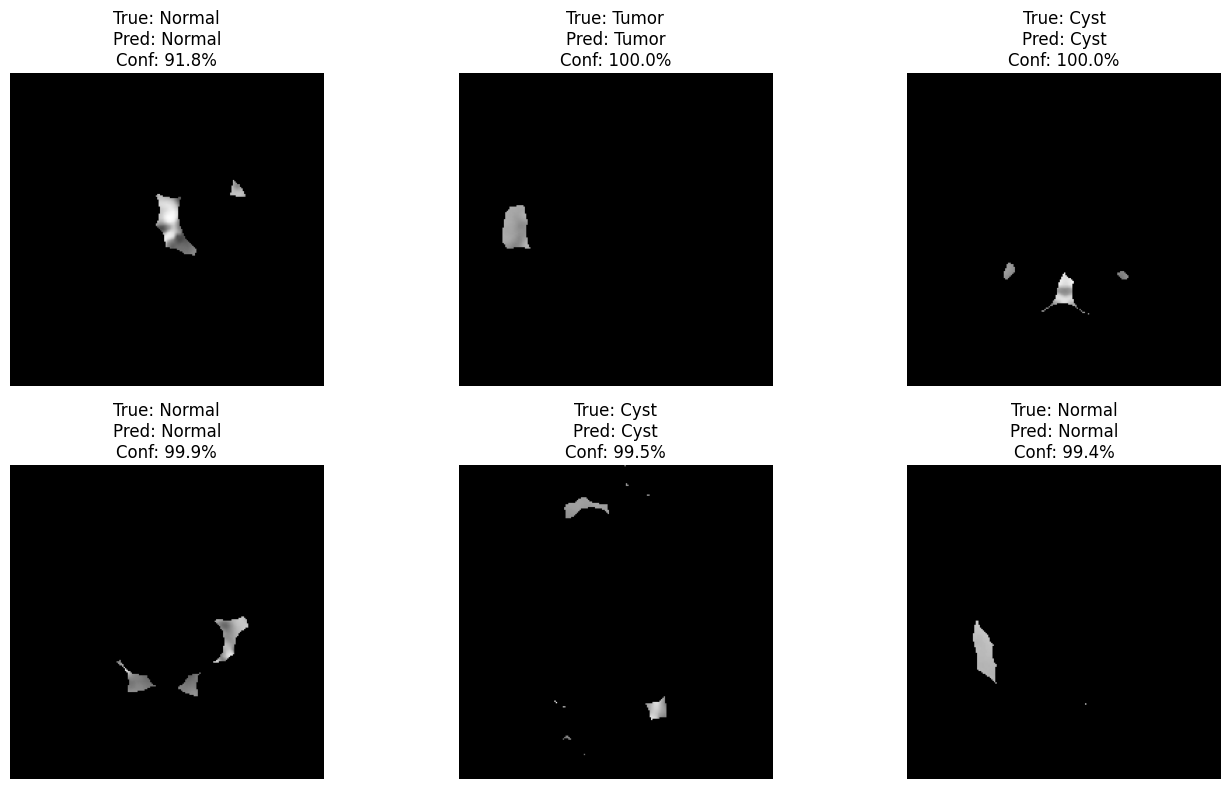

In [ ]:
show_predictions(
    get_efficientnet_b0,
    "/content/drive/MyDrive/efficientnet_b0_best.pth",
    n=6
)


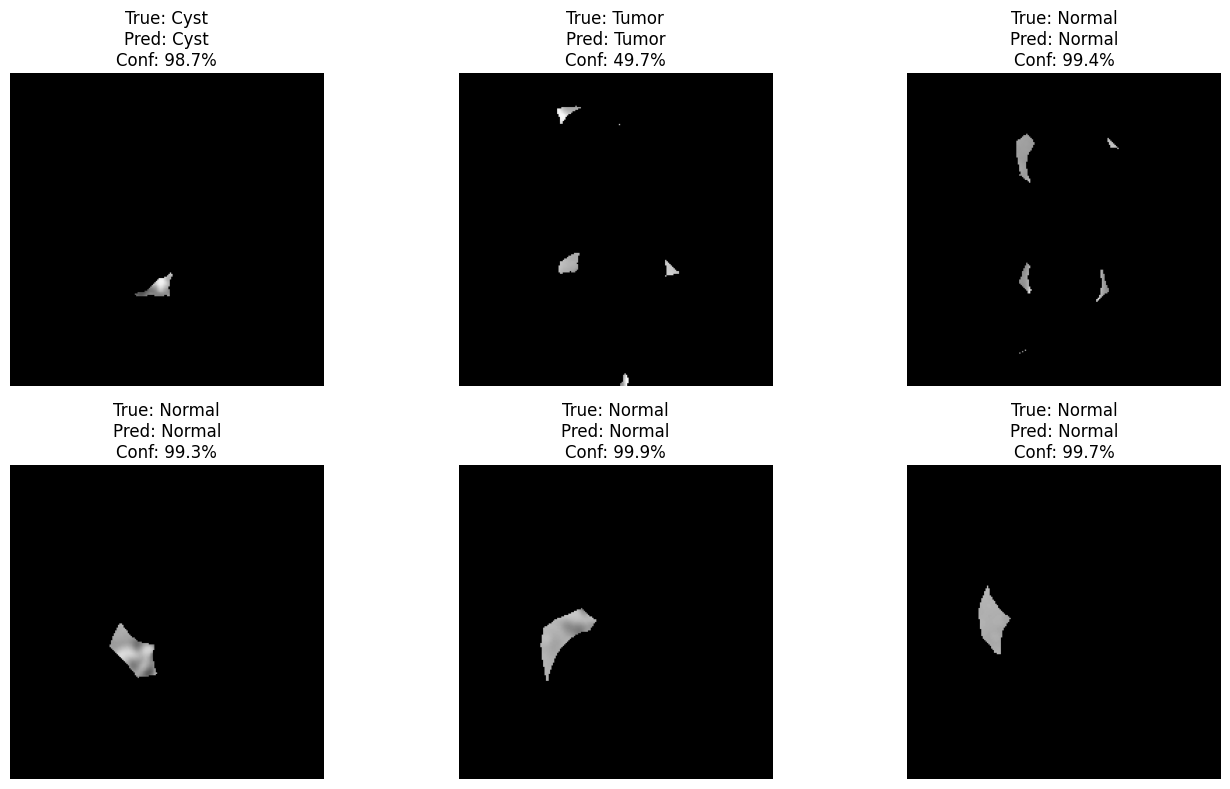

In [ ]:
show_predictions(
    get_densenet121,
    "/content/drive/MyDrive/densenet121_best.pth",
    n=6
)
